In [15]:
import json
from generate_dataset import Sample

# Load dataset
with open("dataset.json", "r") as f:
    dataset = [Sample.model_validate(sample) for sample in json.load(f)]

# Load predictions
with open("predictions.json", "r") as f:
    predictions = json.load(f)

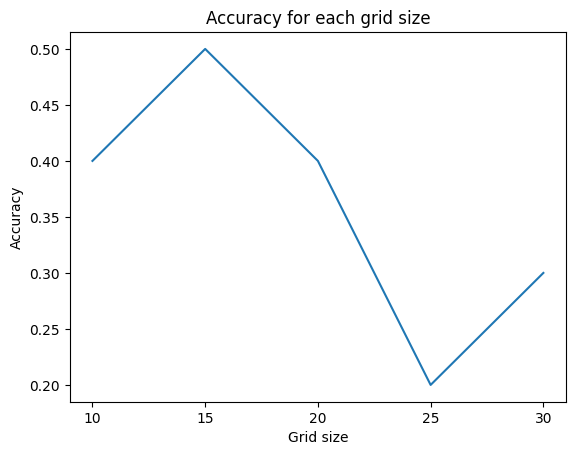

In [16]:
from matplotlib import pyplot as plt


# Plot accuracy for each grid size
grid_sizes = list(range(10, 31, 5))
accuracies = []
for grid_size in grid_sizes:
    grid_size_samples = [sample for sample in dataset if sample.configuration.grid_size == grid_size and sample.configuration.shape_size == 5 and sample.configuration.number_of_shapes == 1]
    grid_size_samples_predictions = [predictions[sample.uuid] for sample in grid_size_samples]
    accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(grid_size_samples_predictions, grid_size_samples)]) / len(grid_size_samples)
    accuracies.append(accuracy)

# Make a title, x label, and y label, x ticks
plt.title("Accuracy for each grid size")
plt.xlabel("Grid size")
plt.ylabel("Accuracy")
plt.xticks(grid_sizes)
plt.plot(grid_sizes, accuracies)
plt.show()


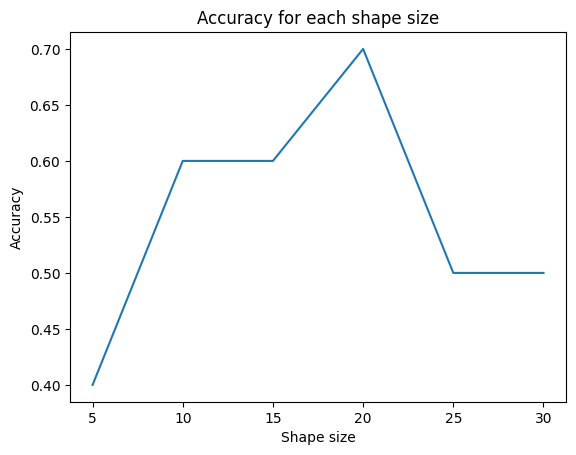

In [17]:
# Plot accuracy for each shape size
shape_sizes = list(range(5, 31, 5))
accuracies = []
for shape_size in shape_sizes:
    shape_size_samples = [sample for sample in dataset if sample.configuration.shape_size == shape_size and sample.configuration.grid_size == 20 and sample.configuration.number_of_shapes == 1]
    shape_size_samples_predictions = [predictions[sample.uuid] for sample in shape_size_samples]
    accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(shape_size_samples_predictions, shape_size_samples)]) / len(shape_size_samples)
    accuracies.append(accuracy)

plt.title("Accuracy for each shape size")
plt.xlabel("Shape size")
plt.ylabel("Accuracy")
plt.xticks(shape_sizes)
plt.plot(shape_sizes, accuracies)
plt.show()

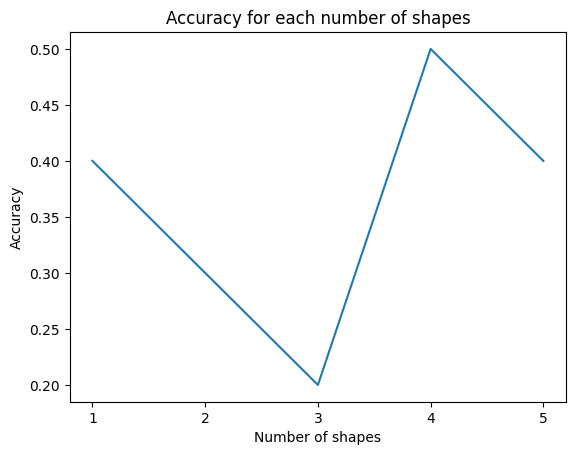

In [18]:
# Plot accuracy for each number of shapes
x_axis = list(range(1, 6))
accuracies = []
for number_of_shapes in x_axis:
    number_of_shapes_samples = [sample for sample in dataset if sample.configuration.number_of_shapes == number_of_shapes and sample.configuration.shape_size == 5 and sample.configuration.grid_size == 20]
    number_of_shapes_samples_predictions = [predictions[sample.uuid] for sample in number_of_shapes_samples]
    accuracy = sum([pred == sample.transformation.type.value for pred, sample in zip(number_of_shapes_samples_predictions, number_of_shapes_samples)]) / len(number_of_shapes_samples)
    accuracies.append(accuracy)

plt.title("Accuracy for each number of shapes")
plt.xlabel("Number of shapes")
plt.ylabel("Accuracy")
plt.xticks(x_axis)
plt.plot(x_axis, accuracies)
plt.show()
